# Analyzing Events Using ctapipe

<div align="center" style="font-size: 2rem">

<img heoght="300px" src="https://cta-observatory.github.io/ctapipe/_images/ctapipe_logo.png" alt="ctapipe"/>


<p style="text-align: center;">Initially presented @ LST Analysis Bootcamp</p>

<p style="text-align: center">Padova, 26.11.2018</p>

<p style="text-align: center">Maximilian Nöthe (@maxnoe) & Kai A. Brügge (@mackaiver)</p>

</div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 14
plt.rcParams["figure.figsize"]

[12.0, 8.0]

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

## General Information

### Design

* DL0 → DL3 analysis

* Currently some R0 → DL2 code to be able to analyze simtel files

* ctapipe is built upon the Scientific Python Stack, core dependencies are
  * numpy
  * scipy
  * astropy
  * numba

### Developement

* ctapipe is developed as Open Source Software (BSD 3-Clause License) at <https://github.com/cta-observatory/ctapipe>

* We use the "Github-Workflow": 
  * Few people (e.g. @kosack, @maxnoe) have write access to the main repository
  * Contributors fork the main repository and work on branches
  * Pull Requests are merged after Code Review and automatic execution of the test suite

* Early developement stage ⇒ backwards-incompatible API changes might and will happen 


### What's there?

* Reading simtel simulation files
* Simple calibration, cleaning and feature extraction functions
* Camera and Array plotting
* Coordinate frames and transformations 
* Stereo-reconstruction using line intersections
  
 

### What's still missing?

* Good integration with machine learning techniques
* IRF calculation 
* Documentation, e.g. formal definitions of coordinate frames  

### What can you do?

* Report issues
  * Hard to get started? Tell us where you are stuck
  * Tell user stories
  * Missing features

* Start contributing
  * ctapipe needs more workpower
  * Implement new reconstruction features

## A simple hillas analysis

### Reading in simtel files

In [3]:
from ctapipe.io import EventSource
from ctapipe.utils.datasets import get_dataset_path

input_url = get_dataset_path("gamma_prod5.simtel.zst")

# EventSource() automatically detects what kind of file we are giving it,
# if already supported by ctapipe
source = EventSource(input_url, max_events=5)

print(type(source))

<class 'ctapipe.io.simteleventsource.SimTelEventSource'>


In [4]:
for event in source:
    print(
        "Id: {}, E = {:1.3f}, Telescopes: {}".format(
            event.count, event.simulation.shower.energy, len(event.r0.tel)
        )
    )

Id: 0, E = 0.073 TeV, Telescopes: 3
Id: 1, E = 1.745 TeV, Telescopes: 14
Id: 2, E = 1.745 TeV, Telescopes: 4
Id: 3, E = 1.745 TeV, Telescopes: 20


Id: 4, E = 1.745 TeV, Telescopes: 31


Each event is a `DataContainer` holding several `Field`s of data, which can be containers or just numbers.
Let's look a one event:

In [5]:
event

ctapipe.containers.ArrayEventContainer:
                       index.*: event indexing information with default None
                          r0.*: Raw Data with default None
                          r1.*: R1 Calibrated Data with default None
                         dl0.*: DL0 Data Volume Reduced Data with default None
                         dl1.*: DL1 Calibrated image with default None
                         dl2.*: DL2 reconstruction info with default None
                  simulation.*: Simulated Event Information with default None
                                with type <class
                                'ctapipe.containers.SimulatedEventContainer'>
                     trigger.*: central trigger information with default None
                         count: number of events processed with default 0
                    pointing.*: Array and telescope pointing positions with
                                default None
                 calibration.*: Container for calibra

In [6]:
source.subarray.camera_types

(CameraDescription(name=CHEC, geometry=CHEC, readout=CHEC),
 CameraDescription(name=FlashCam, geometry=FlashCam, readout=FlashCam),
 CameraDescription(name=LSTCam, geometry=LSTCam, readout=LSTCam),
 CameraDescription(name=NectarCam, geometry=NectarCam, readout=NectarCam))

In [7]:
len(event.r0.tel), len(event.r1.tel)

(31, 31)

### Data calibration

The `CameraCalibrator` calibrates the event (obtaining the `dl1` images).

In [8]:
from ctapipe.calib import CameraCalibrator

calibrator = CameraCalibrator(subarray=source.subarray)

In [9]:
calibrator(event)

### Event displays

Let's use ctapipe's plotting facilities to plot the telescope images

In [10]:
event.dl1.tel.keys()

dict_keys([3, 4, 8, 9, 14, 15, 23, 24, 25, 29, 32, 36, 42, 46, 52, 56, 103, 104, 109, 110, 118, 119, 120, 126, 127, 129, 130, 137, 139, 143, 161])

In [11]:
tel_id = 130

In [12]:
geometry = source.subarray.tel[tel_id].camera.geometry
dl1 = event.dl1.tel[tel_id]

geometry, dl1

(CameraGeometry(name='NectarCam', pix_type=PixelShape.HEXAGON, npix=1855, cam_rot=0.000 deg, pix_rot=40.893 deg, frame=<CameraFrame Frame (focal_length=16.445049285888672 m, rotation=0.0 rad, telescope_pointing=None, obstime=None, location=None)>),
 ctapipe.containers.DL1CameraContainer:
                          image: Numpy array of camera image, after waveform
                                 extraction.Shape: (n_pixel) with default None as
                                 a 1-D array with dtype float32
                      peak_time: Numpy array containing position of the peak of
                                 the pulse as determined by the extractor. Shape:
                                 (n_pixel, ) with default None as a 1-D array
                                 with dtype float32
                     image_mask: Boolean numpy array where True means the pixel
                                 has passed cleaning. Shape: (n_pixel, ) with
                                 defau

In [13]:
dl1.image

array([-0.3856395 ,  1.2851689 ,  1.403967  , ...,  2.6847053 ,
        0.04941979, -1.0566036 ], dtype=float32)

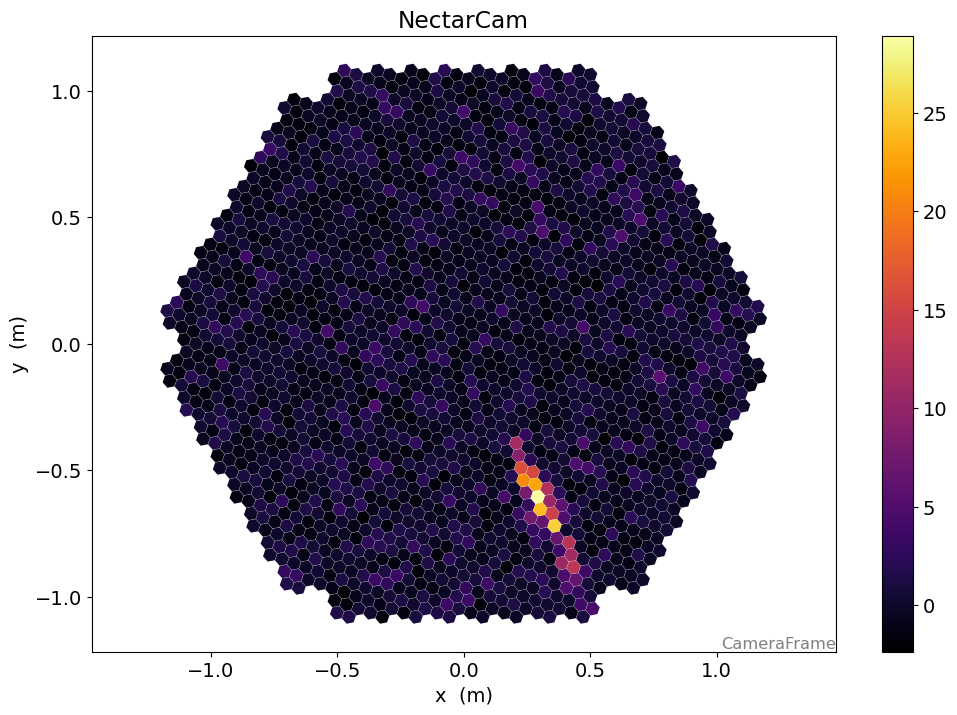

In [14]:
from ctapipe.visualization import CameraDisplay

display = CameraDisplay(geometry)

# right now, there might be one image per gain channel.
# This will change as soon as
display.image = dl1.image
display.add_colorbar()

### Image Cleaning

In [15]:
from ctapipe.image.cleaning import tailcuts_clean

In [16]:
# unoptimized cleaning levels
cleaning_level = {
    "CHEC": (2, 4, 2),
    "LSTCam": (3.5, 7, 2),
    "FlashCam": (3.5, 7, 2),
    "NectarCam": (4, 8, 2),
}

In [17]:
boundary, picture, min_neighbors = cleaning_level[geometry.name]

clean = tailcuts_clean(
    geometry,
    dl1.image,
    boundary_thresh=boundary,
    picture_thresh=picture,
    min_number_picture_neighbors=min_neighbors,
)

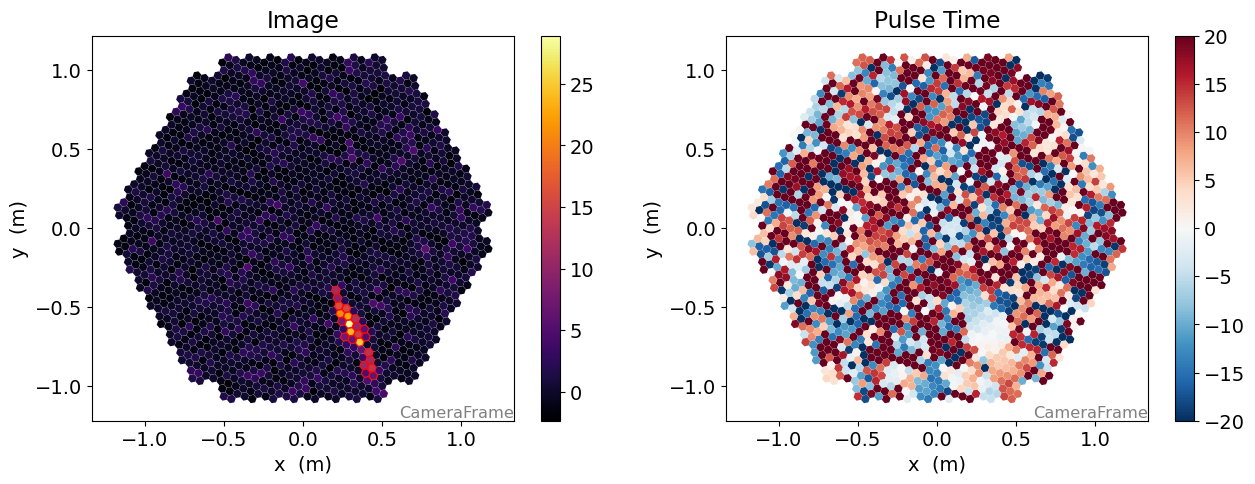

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

d1 = CameraDisplay(geometry, ax=ax1)
d2 = CameraDisplay(geometry, ax=ax2)

ax1.set_title("Image")
d1.image = dl1.image
d1.add_colorbar(ax=ax1)

ax2.set_title("Pulse Time")
d2.image = dl1.peak_time - np.average(dl1.peak_time, weights=dl1.image)
d2.cmap = "RdBu_r"
d2.add_colorbar(ax=ax2)
d2.set_limits_minmax(-20, 20)

d1.highlight_pixels(clean, color="red", linewidth=1)

### Image Parameters

In [19]:
from ctapipe.image import (
    hillas_parameters,
    leakage_parameters,
    concentration_parameters,
)
from ctapipe.image import timing_parameters
from ctapipe.image import number_of_islands
from ctapipe.image import camera_to_shower_coordinates

In [20]:
hillas = hillas_parameters(geometry[clean], dl1.image[clean])

print(hillas)

{'intensity': 303.9444303512573,
 'kurtosis': 2.464947780881624,
 'length': <Quantity 0.14667835 m>,
 'length_uncertainty': <Quantity 0.00509155 m>,
 'phi': <Angle -1.11344351 rad>,
 'psi': <Angle -1.12308339 rad>,
 'r': <Quantity 0.71788425 m>,
 'skewness': 0.36090637987954166,
 'width': <Quantity 0.02584731 m>,
 'width_uncertainty': <Quantity 0.00111159 m>,
 'x': <Quantity 0.31699941 m>,
 'y': <Quantity -0.64410339 m>}


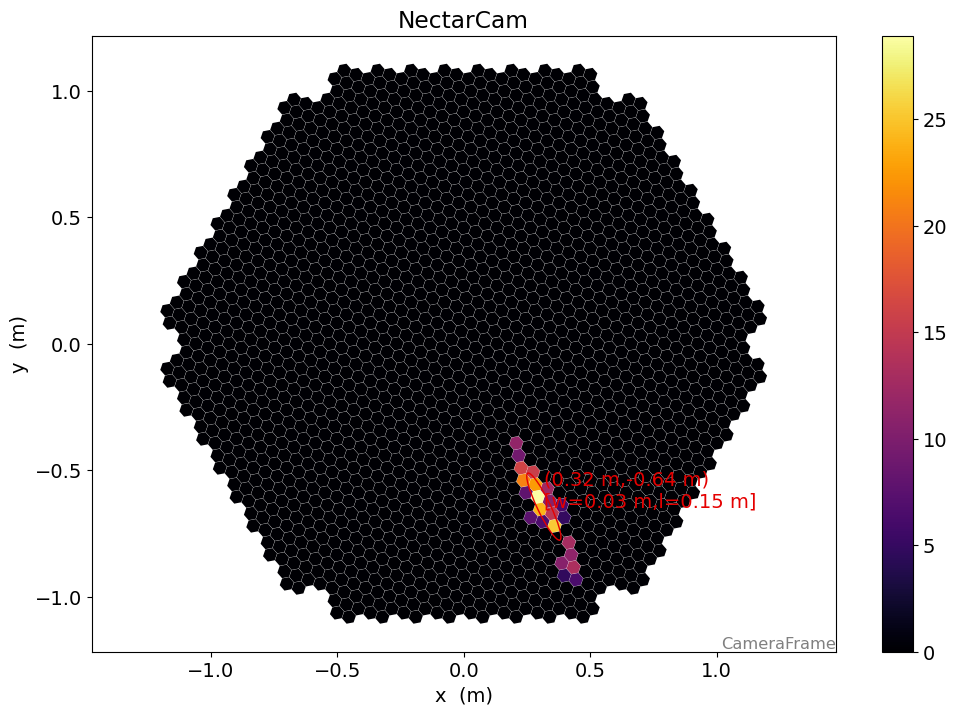

In [21]:
display = CameraDisplay(geometry)

# set "unclean" pixels to 0
cleaned = dl1.image.copy()
cleaned[~clean] = 0.0

display.image = cleaned
display.add_colorbar()

display.overlay_moments(hillas, color="xkcd:red")

In [22]:
timing = timing_parameters(geometry, dl1.image, dl1.peak_time, hillas, clean)

print(timing)

{'deviation': 0.7921518270503362,
 'intercept': 21.812572562414946,
 'slope': <Quantity 31.32320575 1 / m>}


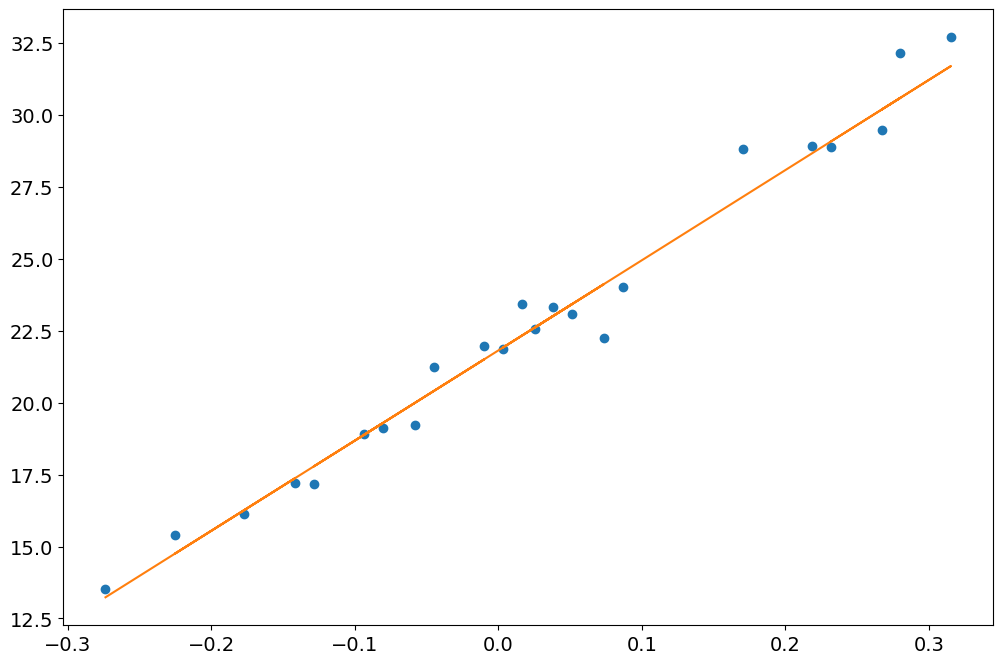

In [23]:
long, trans = camera_to_shower_coordinates(
    geometry.pix_x, geometry.pix_y, hillas.x, hillas.y, hillas.psi
)

plt.plot(long[clean], dl1.peak_time[clean], "o")
plt.plot(long[clean], timing.slope * long[clean] + timing.intercept)

In [24]:
l = leakage_parameters(geometry, dl1.image, clean)
print(l)

{'intensity_width_1': 0.0,
 'intensity_width_2': 0.0,
 'pixels_width_1': 0.0,
 'pixels_width_2': 0.0}


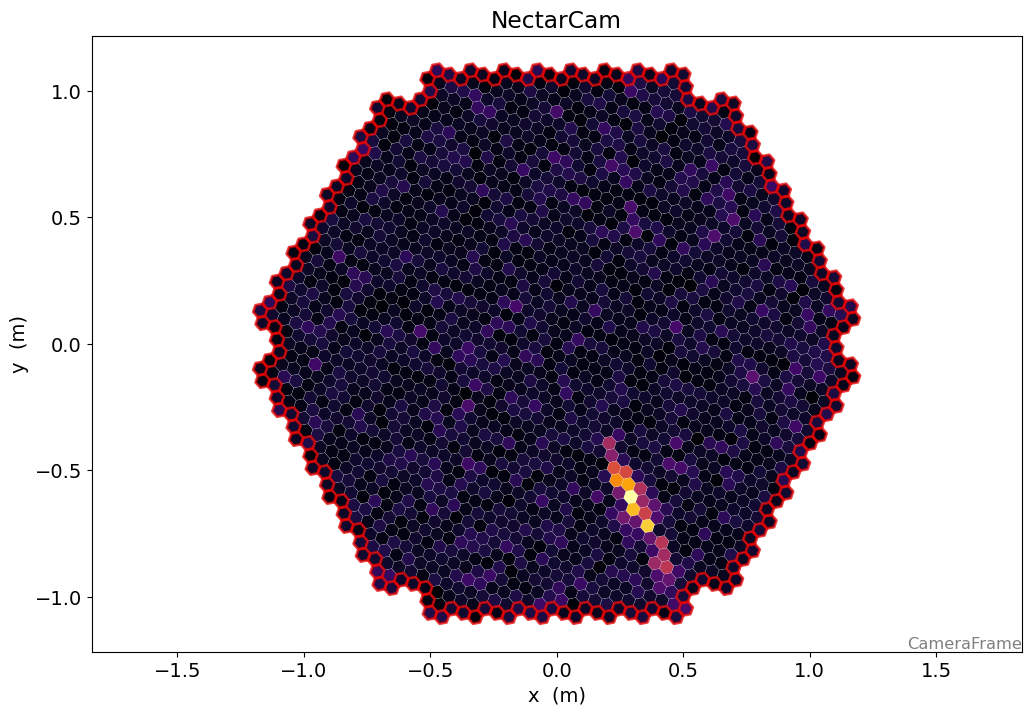

In [25]:
disp = CameraDisplay(geometry)
disp.image = dl1.image
disp.highlight_pixels(geometry.get_border_pixel_mask(1), linewidth=2, color="xkcd:red")

In [26]:
n_islands, island_id = number_of_islands(geometry, clean)

print(n_islands)

2


In [27]:
conc = concentration_parameters(geometry, dl1.image, hillas)
print(conc)

{'cog': 0.2571728392782083,
 'core': 0.4014042974365615,
 'pixel': 0.09514053791448862}


### Putting it all together / Stereo reconstruction


All these steps are now unified in several components configurable through the config system, mainly:

* CameraCalibrator for DL0 → DL1 (Images)
* ImageProcessor for DL1 (Images) → DL1 (Parameters)
* ShowerProcessor for stereo reconstruction of the shower geometry
* DataWriter for writing data into HDF5

A command line tool doing these steps and writing out data in HDF5 format is available as `ctapipe-process`

In [28]:
import astropy.units as u
from astropy.coordinates import SkyCoord, AltAz

from ctapipe.containers import ImageParametersContainer
from ctapipe.io import EventSource
from ctapipe.utils.datasets import get_dataset_path

from ctapipe.calib import CameraCalibrator

from ctapipe.image import ImageProcessor
from ctapipe.reco import ShowerProcessor

from ctapipe.io import DataWriter

from copy import deepcopy
import tempfile

from traitlets.config import Config


image_processor_config = Config(
    {
        "ImageProcessor": {
            "image_cleaner_type": "TailcutsImageCleaner",
            "TailcutsImageCleaner": {
                "picture_threshold_pe": [
                    ("type", "LST_LST_LSTCam", 7.5),
                    ("type", "MST_MST_FlashCam", 8),
                    ("type", "MST_MST_NectarCam", 8),
                    ("type", "SST_ASTRI_CHEC", 7),
                ],
                "boundary_threshold_pe": [
                    ("type", "LST_LST_LSTCam", 5),
                    ("type", "MST_MST_FlashCam", 4),
                    ("type", "MST_MST_NectarCam", 4),
                    ("type", "SST_ASTRI_CHEC", 4),
                ],
            },
        }
    }
)

input_url = get_dataset_path("gamma_prod5.simtel.zst")
source = EventSource(input_url)

calibrator = CameraCalibrator(subarray=source.subarray)
image_processor = ImageProcessor(
    subarray=source.subarray, config=image_processor_config
)
shower_processor = ShowerProcessor(subarray=source.subarray)
horizon_frame = AltAz()

f = tempfile.NamedTemporaryFile(suffix=".hdf5")

with DataWriter(
    source, output_path=f.name, overwrite=True, write_showers=True
) as writer:

    for event in source:
        energy = event.simulation.shower.energy
        n_telescopes_r1 = len(event.r1.tel)
        event_id = event.index.event_id
        print(f"Id: {event_id}, E = {energy:1.3f}, Telescopes (R1): {n_telescopes_r1}")

        calibrator(event)
        image_processor(event)
        shower_processor(event)

        stereo = event.dl2.stereo.geometry["HillasReconstructor"]
        if stereo.is_valid:
            print("  Alt: {:.2f}°".format(stereo.alt.deg))
            print("  Az: {:.2f}°".format(stereo.az.deg))
            print("  Hmax: {:.0f}".format(stereo.h_max))
            print("  CoreX: {:.1f}".format(stereo.core_x))
            print("  CoreY: {:.1f}".format(stereo.core_y))
            print("  Multiplicity: {:d}".format(len(stereo.telescopes)))

        # save a nice event for plotting later
        if event.count == 3:
            plotting_event = deepcopy(event)

        writer(event)

Overwriting /tmp/tmpczbyig21.hdf5


Id: 4009, E = 0.073 TeV, Telescopes (R1): 3


  Alt: 70.18°
  Az: 0.41°
  Hmax: 12638 m
  CoreX: -113.2 m
  CoreY: 366.5 m
  Multiplicity: 3
Id: 5101, E = 1.745 TeV, Telescopes (R1): 14


  Alt: 70.00°
  Az: 359.95°
  Hmax: 8487 m
  CoreX: -739.5 m
  CoreY: -268.4 m
  Multiplicity: 10


Id: 5103, E = 1.745 TeV, Telescopes (R1): 4
  Alt: 70.21°
  Az: 0.50°
  Hmax: 10324 m
  CoreX: 832.1 m
  CoreY: 945.4 m
  Multiplicity: 2


Id: 5104, E = 1.745 TeV, Telescopes (R1): 20
  Alt: 70.16°
  Az: 0.07°
  Hmax: 8881 m
  CoreX: -518.3 m
  CoreY: -451.5 m
  Multiplicity: 15


Id: 5105, E = 1.745 TeV, Telescopes (R1): 31


  Alt: 70.02°
  Az: 0.13°
  Hmax: 8736 m
  CoreX: -327.7 m
  CoreY: 408.8 m
  Multiplicity: 25


Id: 5108, E = 1.745 TeV, Telescopes (R1): 3
  Alt: 69.95°
  Az: 359.79°
  Hmax: 8440 m
  CoreX: -1304.5 m
  CoreY: 205.6 m
  Multiplicity: 2


Id: 5109, E = 1.745 TeV, Telescopes (R1): 8
  Alt: 69.62°
  Az: 359.93°
  Hmax: 9020 m
  CoreX: -1067.6 m
  CoreY: 480.5 m
  Multiplicity: 3


In [29]:
from astropy.coordinates.angle_utilities import angular_separation
import pandas as pd

from ctapipe.io import TableLoader

loader = TableLoader(f.name, load_dl2=True, load_simulated=True)

events = loader.read_subarray_events()

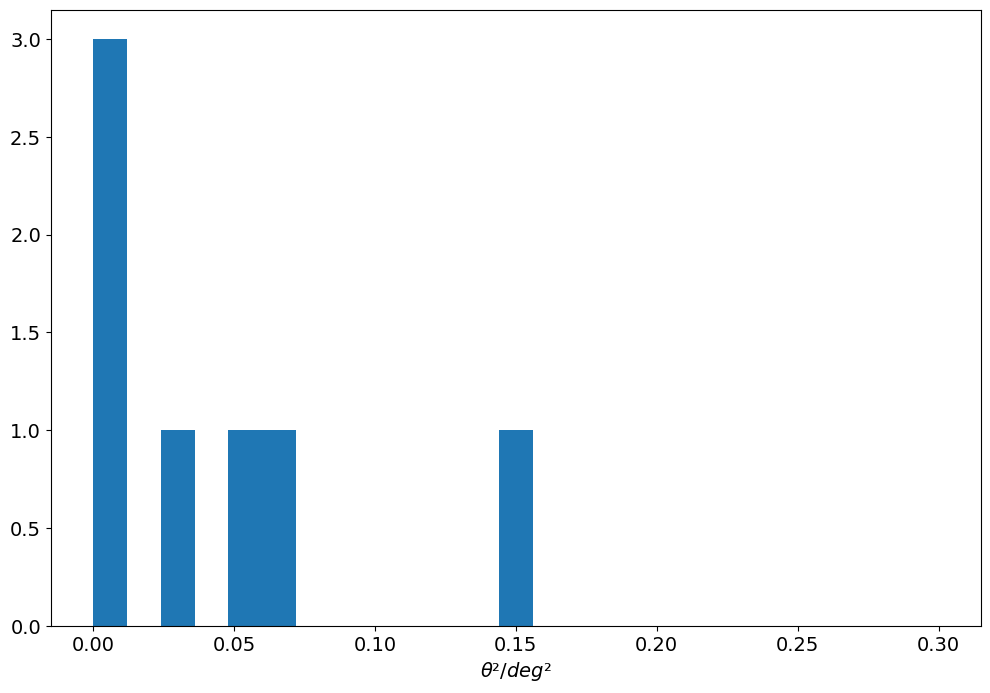

In [30]:
theta = angular_separation(
    events["HillasReconstructor_az"].quantity,
    events["HillasReconstructor_alt"].quantity,
    events["true_az"].quantity,
    events["true_alt"].quantity,
)

plt.hist(theta.to_value(u.deg) ** 2, bins=25, range=[0, 0.3])
plt.xlabel(r"$\theta² / deg²$")
None

## ArrayDisplay


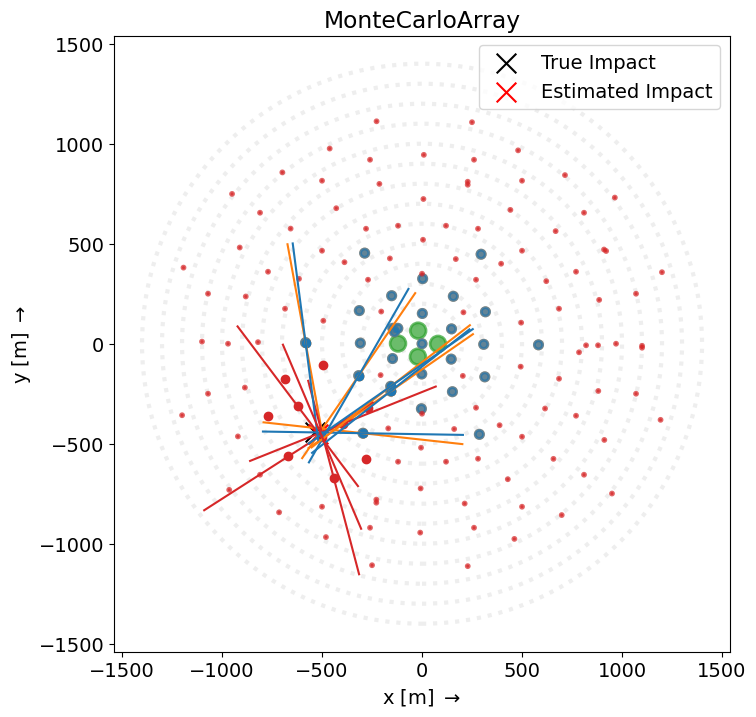

In [31]:
from ctapipe.visualization import ArrayDisplay


angle_offset = plotting_event.pointing.array_azimuth

plotting_hillas = {
    tel_id: dl1.parameters.hillas for tel_id, dl1 in plotting_event.dl1.tel.items()
}

plotting_core = {
    tel_id: dl1.parameters.core.psi for tel_id, dl1 in plotting_event.dl1.tel.items()
}


disp = ArrayDisplay(source.subarray)

disp.set_line_hillas(plotting_hillas, plotting_core, 500)

plt.scatter(
    plotting_event.simulation.shower.core_x,
    plotting_event.simulation.shower.core_y,
    s=200,
    c="k",
    marker="x",
    label="True Impact",
)
plt.scatter(
    plotting_event.dl2.stereo.geometry["HillasReconstructor"].core_x,
    plotting_event.dl2.stereo.geometry["HillasReconstructor"].core_y,
    s=200,
    c="r",
    marker="x",
    label="Estimated Impact",
)

plt.legend()
# plt.xlim(-400, 400)
# plt.ylim(-400, 400)

### Reading the LST dl1 data


In [32]:
loader = TableLoader(f.name, load_simulated=True, load_dl1_parameters=True)

dl1_table = loader.read_telescope_events(["LST_LST_LSTCam"])

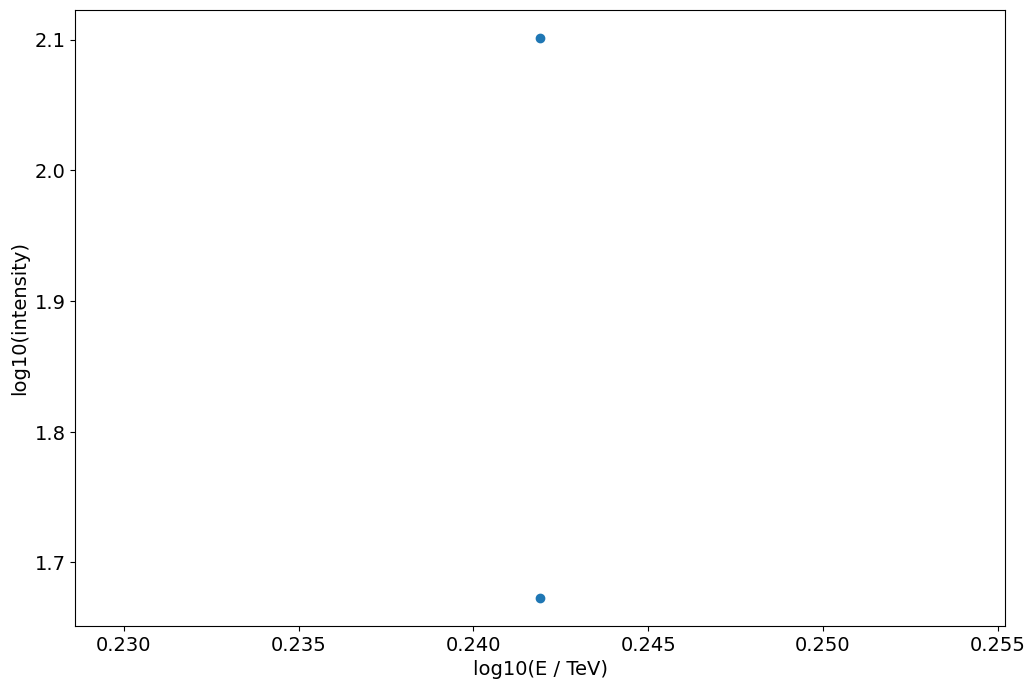

In [33]:
plt.scatter(
    np.log10(dl1_table["true_energy"].quantity / u.TeV),
    np.log10(dl1_table["hillas_intensity"]),
)
plt.xlabel("log10(E / TeV)")
plt.ylabel("log10(intensity)")
None

## Isn't python slow?

* Many of you might have heard: "Python is slow".
* That's trueish.
* All python objects are classes living on the heap, even integers.
* Looping over lots of "primitives" is quite slow compared to other languages.

⇒ Vectorize as much as possible using numpy  
⇒ Use existing interfaces to fast C / C++ / Fortran code  
⇒ Optimize using numba  

**But: "Premature Optimization is the root of all evil" — Donald Knuth**

So profile to find exactly what is slow.

### Why use python then?

* Python works very well as *glue* for libraries of all kinds of languages
* Python has a rich ecosystem for data science, physics, algorithms, astronomy

### Example: Number of Islands

Find all groups of pixels, that survived the cleaning

In [34]:
from ctapipe.image import toymodel
from ctapipe.instrument import SubarrayDescription


geometry = loader.subarray.tel[1].camera.geometry

Let's create a toy images with several islands;

In [35]:
np.random.seed(42)

image = np.zeros(geometry.n_pixels)


for i in range(9):

    model = toymodel.Gaussian(
        x=np.random.uniform(-0.8, 0.8) * u.m,
        y=np.random.uniform(-0.8, 0.8) * u.m,
        width=np.random.uniform(0.05, 0.075) * u.m,
        length=np.random.uniform(0.1, 0.15) * u.m,
        psi=np.random.uniform(0, 2 * np.pi) * u.rad,
    )

    new_image, sig, bg = model.generate_image(
        geometry, intensity=np.random.uniform(1000, 3000), nsb_level_pe=5
    )
    image += new_image

In [36]:
clean = tailcuts_clean(
    geometry,
    image,
    picture_thresh=10,
    boundary_thresh=5,
    min_number_picture_neighbors=2,
)

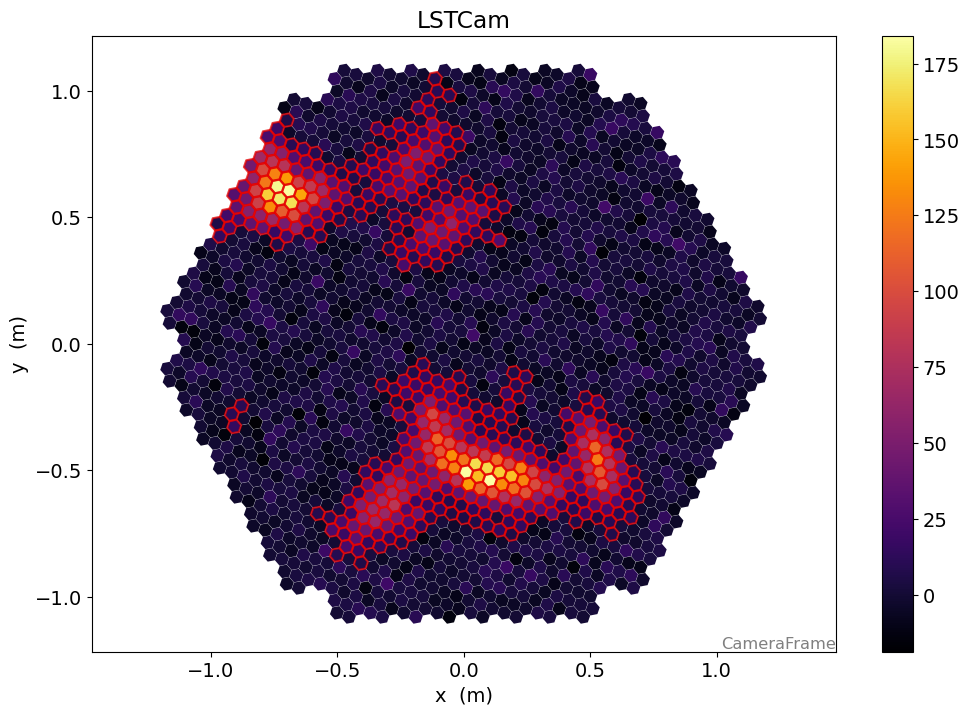

In [37]:
disp = CameraDisplay(geometry)
disp.image = image
disp.highlight_pixels(clean, color="xkcd:red", linewidth=1.5)
disp.add_colorbar()

In [38]:
def num_islands_python(camera, clean):
    """A breadth first search to find connected islands of neighboring pixels in the cleaning set"""

    # the camera geometry has a [n_pixel, n_pixel] boolean array
    # that is True where two pixels are neighbors
    neighbors = camera.neighbor_matrix

    island_ids = np.zeros(camera.n_pixels)
    current_island = 0

    # a set to remember which pixels we already visited
    visited = set()

    # go only through the pixels, that survived cleaning
    for pix_id in np.where(clean)[0]:
        if pix_id not in visited:
            # remember that we already checked this pixel
            visited.add(pix_id)

            # if we land in the outer loop again, we found a new island
            current_island += 1
            island_ids[pix_id] = current_island

            # now check all neighbors of the current pixel recursively
            to_check = set(np.where(neighbors[pix_id] & clean)[0])
            while to_check:
                pix_id = to_check.pop()

                if pix_id not in visited:
                    visited.add(pix_id)
                    island_ids[pix_id] = current_island

                    to_check.update(np.where(neighbors[pix_id] & clean)[0])

    n_islands = current_island
    return n_islands, island_ids

In [39]:
n_islands, island_ids = num_islands_python(geometry, clean)

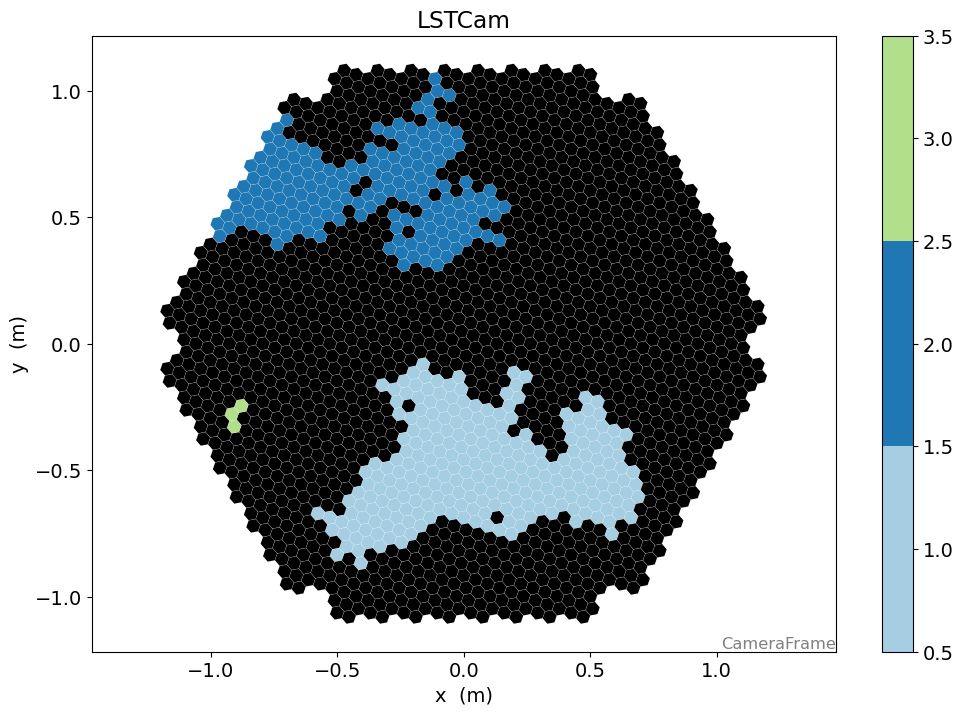

In [40]:
from matplotlib.colors import ListedColormap

cmap = plt.get_cmap("Paired")
cmap = ListedColormap(cmap.colors[:n_islands])
cmap.set_under("k")

disp = CameraDisplay(geometry)
disp.image = island_ids
disp.cmap = cmap
disp.set_limits_minmax(0.5, n_islands + 0.5)
disp.add_colorbar()

In [41]:
%timeit num_islands_python(geometry, clean)

2.43 ms ± 6.47 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [42]:
from scipy.sparse.csgraph import connected_components


def num_islands_scipy(geometry, clean):
    neighbors = geometry.neighbor_matrix_sparse

    clean_neighbors = neighbors[clean][:, clean]
    num_islands, labels = connected_components(clean_neighbors, directed=False)

    island_ids = np.zeros(geometry.n_pixels)
    island_ids[clean] = labels + 1

    return num_islands, island_ids

In [43]:
n_islands_s, island_ids_s = num_islands_scipy(geometry, clean)

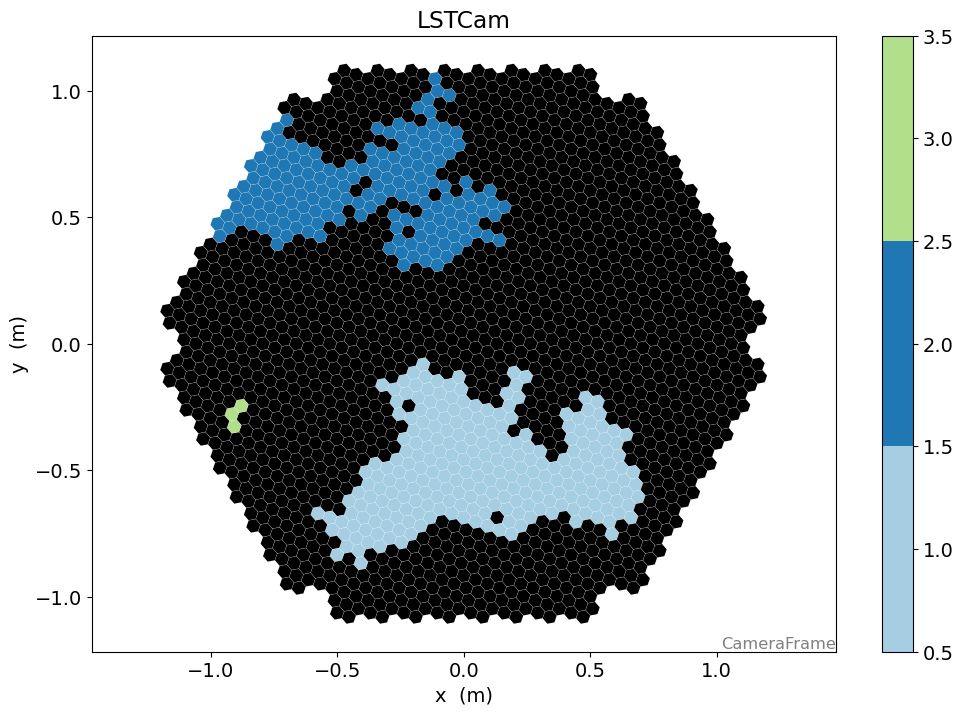

In [44]:
disp = CameraDisplay(geometry)
disp.image = island_ids_s
disp.cmap = cmap
disp.set_limits_minmax(0.5, n_islands_s + 0.5)
disp.add_colorbar()

In [45]:
%timeit num_islands_scipy(geometry, clean)

407 µs ± 1.34 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


**A lot less code, and a factor 3 speed improvement**

Finally, current ctapipe implementation is using numba:

In [46]:
%timeit number_of_islands(geometry, clean)

33.1 µs ± 37 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
